## Imports

In [31]:
"""Imports"""

import re
import json
from os import listdir
from os.path import isfile, join
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


## filter_res_by_cut_number

In [32]:
def filter_res_by_cut_number(cut_number, res_data):

    output = []
    for d in res_data:
        if d['number_of_cuts'] == cut_number:
            output.append(d)
    return output

## normalize_to_selected_frag_number

In [33]:
def normalize_to_selected_frag_number(res_data: list, properties_to_normalize: list[str], selected_frag_number: str, reciprocal: list[bool], keep_selected_frag_number: bool) -> list:

    # Initialize a dictionary to hold the sum of output values and count for each item
    item_outputs = {}

    # Loop through the dataset to group them based on sequence and cut number
    for d in res_data:
        key = (d["partition_search_method"], d["sequence"])
        if key not in set(item_outputs.keys()):
            item_outputs[key] = [d]
        if d not in item_outputs[key]:
            item_outputs[key].append(d)

    # Aggregate each group to one dict
    output = []
    for lst in item_outputs.values():
        for d in lst:
            out_d = d.copy()
            for property, reciprocal_ in zip(properties_to_normalize, reciprocal):
                property_of_each_frag_number = {d['number_of_fragments']: d[property] for d in lst}
                if property_of_each_frag_number[selected_frag_number] == 0:
                    normalized_value = float('nan')
                elif reciprocal_:
                    normalized_value = property_of_each_frag_number[selected_frag_number]/d[property]
                else:
                    normalized_value = d[property]/property_of_each_frag_number[selected_frag_number]
                out_d.update({f"{property}_normalized_to_{selected_frag_number}": normalized_value})
            output.append(out_d)

    if not keep_selected_frag_number:
        output = [d for d in output if d['number_of_fragments'] != selected_frag_number]

    return output


## normalize_to_selected_search_method

In [34]:
def normalize_to_selected_search_method(res_data: list, properties_to_normalize: list[str], selected_search_method: str, reciprocal: list[bool], keep_selected_search_method: bool) -> list:

    # Initialize a dictionary to hold the sum of output values and count for each item
    item_outputs = {}

    # Loop through the dataset to group them based on sequence and cut number
    for d in res_data:
        key = (d["number_of_cuts"], d["sequence"])
        if key not in set(item_outputs.keys()):
            item_outputs[key] = [d]
        if d not in item_outputs[key]:
            item_outputs[key].append(d)

    # Aggregate each group to one dict
    output = []
    for lst in item_outputs.values():
        for d in lst:
            out_d = d.copy()
            for property, reciprocal_ in zip(properties_to_normalize, reciprocal):
                property_of_each_method = {d['partition_search_method']: d[property] for d in lst}
                if property_of_each_method[selected_search_method] == 0:
                    normalized_value = float('nan')
                elif reciprocal_:
                    normalized_value = property_of_each_method[selected_search_method]/d[property]
                else:
                    normalized_value = d[property]/property_of_each_method[selected_search_method]
                out_d.update({f"{property}_normalized_to_{selected_search_method}": normalized_value})
            output.append(out_d)

    if not keep_selected_search_method:
        output = [d for d in output if d['partition_search_method'] != keep_selected_search_method]

    return output


## jitter_box_plot

In [35]:
def convert_plot_label_txt(txt):
    return re.sub("Of", "of", str.title(re.sub("_"," ",txt)))


def jitter_box_plot(x_axis, y_axis, df, my_palette, logy=True):

    plt.figure(figsize=(8, 5))
    if logy:
        plt.yscale('symlog')
    else:
        plt.yscale('linear')

    # Using seaborn to plot with jitter and boxplot
    sns.boxplot(x=x_axis, y=y_axis, hue='assembly_condition', data=df, palette=my_palette[:6], showfliers = False,
                boxprops=dict(facecolor='white', edgecolor="black", alpha=0.5),
                medianprops=dict(alpha=0.5),
                whiskerprops=dict(alpha=0.5),
                capprops=dict(alpha=0.5))
    sns.stripplot(x=x_axis, y=y_axis, hue='assembly_condition', data=df, palette=my_palette[:6], dodge=True,
                  jitter=True, alpha=0.5, s=4, edgecolor='auto')
    plt.xlabel(convert_plot_label_txt(x_axis), fontsize=14)
    label_loc = "upper left"
    if y_axis == "normalized":
        plt.ylabel(f"Elapsed Time {convert_plot_label_txt(y_axis)}", fontsize=14)
    else:
        plt.ylabel(f"{convert_plot_label_txt(y_axis)}", fontsize=14)
    plt.title(f'{convert_plot_label_txt(y_axis)} vs {convert_plot_label_txt(x_axis)}',
              fontsize=16,
              pad=20)

    if y_axis == "ligation_fidelity":
        plt.ylim([0.95,1.05])
        plt.ylabel(f"{convert_plot_label_txt(y_axis)}", fontsize=14)

    if y_axis == "cost":
        plt.ylim([100,10000])
        label_loc = "upper right"
        plt.ylabel(f"{convert_plot_label_txt(y_axis)} (\$, 0.1\$/bp)", fontsize=14)

    if y_axis == "number_of_partitions_checked":
        plt.ylabel(f"{convert_plot_label_txt(y_axis)} (log scale)", fontsize=14)

    # Adjust legend to avoid duplicate entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    legend = plt.legend(by_label.values(), by_label.keys(), title='Assembly Condition',
                        loc=label_loc,
                        ncols=1,
                        fontsize=12,
                        title_fontsize=12)
    for lh in legend.legend_handles:
        lh.set_alpha(1)
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((0, 0, 0, 0))

    return plt

## Import and prepare data

In [36]:
"""Import and prepare data"""
from proseqteleporter.utils.utils import compute_lib_complexity

parent_dirs = [
    r"C:\Users\GOFKV\PycharmProjects\proseqteleporter\experiments\assembly_cond\fix_cplx_diff_muts_inputs_T4_01h_25C",
    r"C:\Users\GOFKV\PycharmProjects\proseqteleporter\experiments\assembly_cond\fix_cplx_diff_muts_inputs_T7_18h_25C",
    r"C:\Users\GOFKV\PycharmProjects\proseqteleporter\experiments\assembly_cond\fix_cplx_diff_muts_inputs_T7_18h_37C"
]

res_data = []
count = 0
for parent_dir in parent_dirs:
    result_dirs = [d for d in listdir(parent_dir) if not isfile(join(parent_dir, d))]
    print(result_dirs)

    for d in result_dirs:
        if re.search('checkpoint',d):
            continue
        param_file = join(parent_dir, d, "results", "params_dist_mut_1.json")
        with open(param_file, 'r') as fp:
            param = json.load(fp)
        mutations_0idx = param['mutations_0idx']
        linked_mutations_0idx = param['linked_mutations_0idx']
        assembly_cond = re.sub("^.*FileS[0-9][0-9]_|[.xlsx]","",param["fidelity_data_path"])
        # assembly_cond = param["fidelity_data_path"]
        diversity = compute_lib_complexity(mutations=mutations_0idx, linked_mutations=linked_mutations_0idx)

        result_files = [join(parent_dir, d, "results", f)
                        for f in listdir(join(parent_dir, d, "results")) if re.search('\dfrags',f)]
        # print(result_files)

        for file_path in result_files:
            count +=1
            with open(file_path, 'r') as fp:
                res_per_cut = json.load(fp)

                res_dict_ = {}
                number_checked = res_per_cut["number_of_partitions_checked"]
                uq_number_checked = res_per_cut["num_of_checked_unique_partitions"]
                hard_constraint_violations = sum([v for v in res_per_cut["hard_constraint_violations"].values()])
                if len(res_per_cut["sel_partitions"]) > 0:
                    ligation_fidelity = res_per_cut["sel_partitions"][0]["ligation_fidelity"]
                    fragment_length_unevenness = res_per_cut["sel_partitions"][0]["fragment_length_unevenness"]
                    cost = res_per_cut["sel_partitions"][0]["cost"]
                    top_partition = res_per_cut["sel_partitions"][0]["partition"]
                    fusion_sites = res_per_cut["sel_partitions"][0]["fusion_sites"]
                else:
                    print(file_path)
                    print(res_per_cut["hard_constraint_violations"])
                    continue
                    # ligation_fidelity = fragment_length_unevenness = cost = float("nan")
                res_dict_.update({
                    'fusion_sites':fusion_sites,
                    'partition':top_partition,
                    'partition_search_method':"distribute mut and only keep the best",
                    'assembly_condition': assembly_cond,
                    'sequence':param['s'],
                    'complexity': diversity,
                    'seq_length':len(param["s"]),
                    'mutation_positions':len(mutations_0idx),
                    'mutation_variations':sum([len(mut['aa']) for mut in mutations_0idx]),
                    'number_of_cuts':res_per_cut['number_of_cuts'],
                    'number_of_fragments':res_per_cut['number_of_cuts']+1,
                    'elapsed_time':res_per_cut['elapsed_time']/60,
                    "ligation_fidelity":ligation_fidelity,
                    "fragment_length_unevenness":fragment_length_unevenness,
                    "cost":cost,
                    "base_count":cost/0.11,
                    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5204324/
                    "number_of_partitions_checked":number_checked,
                    "num_of_checked_unique_partitions":uq_number_checked,
                    "pass_constraint_percentage": (number_checked-hard_constraint_violations)/number_checked * 100
                                 })
                res_data.append(res_dict_)
                res_dict_cp_ = res_dict_.copy()
                # res_dict_cp_.update({"cost":cost/0.06*0.18})
                # res_data.append(res_dict_cp_)
print(count)
df = pd.DataFrame([d for d in res_data if d['partition_search_method'] == "distribute mut and only keep the best"])
df

['input_rep0_2024-06-26output', 'input_rep10_2024-06-26output', 'input_rep11_2024-06-26output', 'input_rep12_2024-06-26output', 'input_rep13_2024-06-26output', 'input_rep14_2024-06-26output', 'input_rep15_2024-06-26output', 'input_rep16_2024-06-26output', 'input_rep17_2024-06-26output', 'input_rep18_2024-06-26output', 'input_rep19_2024-06-26output', 'input_rep1_2024-06-26output', 'input_rep20_2024-06-26output', 'input_rep21_2024-06-26output', 'input_rep22_2024-06-26output', 'input_rep23_2024-06-26output', 'input_rep24_2024-06-26output', 'input_rep25_2024-06-26output', 'input_rep26_2024-06-26output', 'input_rep27_2024-06-26output', 'input_rep28_2024-06-26output', 'input_rep29_2024-06-26output', 'input_rep2_2024-06-26output', 'input_rep30_2024-06-26output', 'input_rep31_2024-06-26output', 'input_rep32_2024-06-26output', 'input_rep33_2024-06-26output', 'input_rep34_2024-06-26output', 'input_rep35_2024-06-26output', 'input_rep36_2024-06-26output', 'input_rep37_2024-06-26output', 'input_rep

,fusion_sites,partition,partition_search_method,assembly_condition,sequence,complexity,seq_length,mutation_positions,mutation_variations,number_of_cuts,number_of_fragments,elapsed_time,ligation_fidelity,fragment_length_unevenness,cost,base_count,number_of_partitions_checked,num_of_checked_unique_partitions,pass_constraint_percentage
0,[ACAT],[50],distribute mut and only keep the best,T4_01h_25C,GYMRFECQVIGDETFDKVEQMILGPCTQWPMHYDMQPNAYRACRDI...,10000,100,8,20,1,2,0.010500,1.00,0.000,9360.0,85090.909091,9,9,100.000000
1,"[AGTT, AAGC]","[49, 71]",distribute mut and only keep the best,T4_01h_25C,GYMRFECQVIGDETFDKVEQMILGPCTQWPMHYDMQPNAYRACRDI...,10000,100,8,20,2,3,0.018333,1.00,1.227,1170.0,10636.363636,99,99,96.969697
2,"[AGTT, AAGA, ACGC]","[49, 65, 81]",distribute mut and only keep the best,T4_01h_25C,GYMRFECQVIGDETFDKVEQMILGPCTQWPMHYDMQPNAYRACRDI...,10000,100,8,20,3,4,0.217667,1.00,2.062,1026.0,9327.272727,1980,1980,95.606061
3,[AACC],[50],distribute mut and only keep the best,T4_01h_25C,SQISRKTMEFMHQTSAWTCLERLGQVAEVPHAWFYPPRNSCMATWC...,10000,100,7,24,1,2,0.011833,1.00,0.000,3600.0,32727.272727,35,35,100.000000
4,"[ACAC, AACG]","[31, 72]",distribute mut and only keep the best,T4_01h_25C,SQISRKTMEFMHQTSAWTCLERLGQVAEVPHAWFYPPRNSCMATWC...,10000,100,7,24,2,3,0.010833,1.00,0.464,1440.0,13090.909091,6,6,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,"[ACTG, AGGA, CGCA]","[27, 51, 76]",distribute mut and only keep the best,T7_18h_37C,NEINCDIGKLMRRLSEPMFHQARSRNHCPCPPIIKAGKNYFKRPII...,10000,100,6,28,3,4,3.017333,0.99,0.125,2106.0,19145.454545,3200,3200,95.500000
587,[ATCT],[51],distribute mut and only keep the best,T7_18h_37C,RHQWLFFNGNYTATRRIKVNGVRRDQMLTGVITLQFCGCNVPHCWH...,10000,100,7,24,1,2,0.010500,0.99,0.041,4500.0,40909.090909,6,6,100.000000
588,"[CGGA, ATAG]","[37, 68]",distribute mut and only keep the best,T7_18h_37C,RHQWLFFNGNYTATRRIKVNGVRRDQMLTGVITLQFCGCNVPHCWH...,10000,100,7,24,2,3,0.069833,0.99,0.194,1440.0,13090.909091,192,192,100.000000
589,"[AAGG, AAGC, AGAT]","[24, 52, 77]",distribute mut and only keep the best,T7_18h_37C,RHQWLFFNGNYTATRRIKVNGVRRDQMLTGVITLQFCGCNVPHCWH...,10000,100,7,24,3,4,5.178000,0.99,0.217,810.0,7363.636364,2346,2346,100.000000


## Plot bar chart

In [44]:
counters = []
n=0
for nof, sub_df_ in df.groupby(['number_of_fragments']):
    counter = {'number_of_fragments':nof[0]}
    for s, sub_df in sub_df_.groupby(['sequence']):
        n += 1
        if sub_df.shape[0] != 3:
            print(sub_df)
            continue
        sub_df['partition'] = sub_df.apply(lambda row: tuple(row['partition']), axis=1)
        sub_df['fusion_sites'] = sub_df.apply(lambda row: tuple(row['fusion_sites']), axis=1)
        flag_dups = sub_df[['partition','fusion_sites']].duplicated(keep=False)
        if flag_dups.sum() == sub_df.shape[0]:
            senario = 'all identical'
        elif flag_dups.sum() == 0:
            senario = 'all distinct'
        else:
            senario = sorted(tuple(sub_df['assembly_condition'][flag_dups]))
            senario = f'{senario[0]}={senario[1]}'
        if senario not in counter:
            counter.update({senario:1})
        else:
            counter[senario] += 1
    counters.append(counter)

print(n)
df_for_bar_chart = pd.DataFrame(counters).fillna(0)
df_for_bar_chart['Total']= df_for_bar_chart.iloc[:, 1:].sum(axis=1)
df_for_bar_chart_percentage = df_for_bar_chart.astype('float64').astype({'number_of_fragments': 'int32'})

for col in range(1,6):
    df_for_bar_chart_percentage.iloc[:,col] = df_for_bar_chart_percentage.iloc[:,col]/df_for_bar_chart_percentage['Total']*100
df_for_bar_chart = df_for_bar_chart.drop(['Total'], axis=1)
df_for_bar_chart_percentage = df_for_bar_chart_percentage.drop(['Total'], axis=1)


197


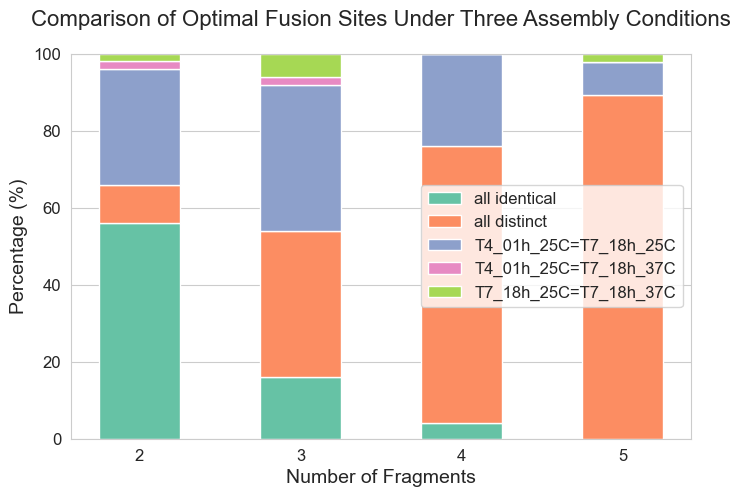

In [47]:
def plot_bar_chart(df, ylabel):
    # plt.figure(figsize=(8, 5))
    groups = df['number_of_fragments'].astype("string")
    values = df.drop(columns=['number_of_fragments']).transpose().to_numpy()
    labels = df.drop(columns=['number_of_fragments']).columns
    width = 0.5
    my_palette_map = sns.color_palette("Set2", n_colors=values.shape[0]).as_hex()

    fig, ax = plt.subplots(figsize=(8, 5))
    plt.title(f'Comparison of Optimal Fusion Sites Under Three Assembly Conditions', fontsize=16, pad=20)

    # Stacked bar chart with loop
    for i in range(values.shape[0]):
      ax.bar(groups, values[i], bottom = np.sum(values[:i], axis = 0), width = width, color=my_palette_map[i], label=labels[i])
    ax.legend(fontsize=12)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xlabel('Number of Fragments', fontsize=14)
    # We change the fontsize of minor ticks label
    ax.tick_params(axis='both', which='major', labelsize=12)

plot_bar_chart(df_for_bar_chart_percentage, 'Percentage (%)')

## Plotting - Jitter + Box Plots

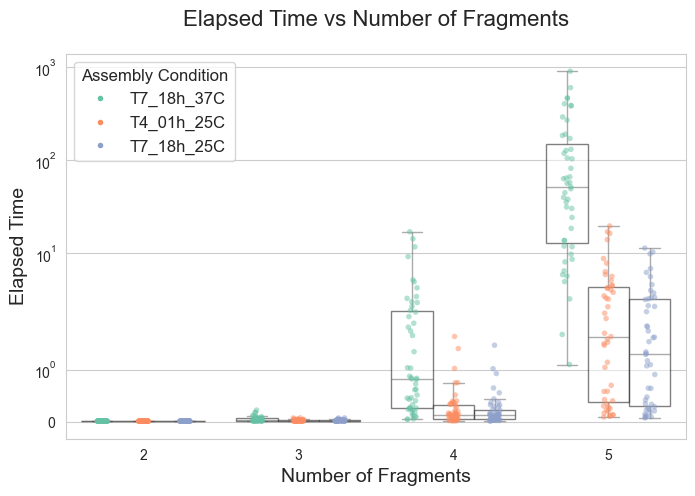

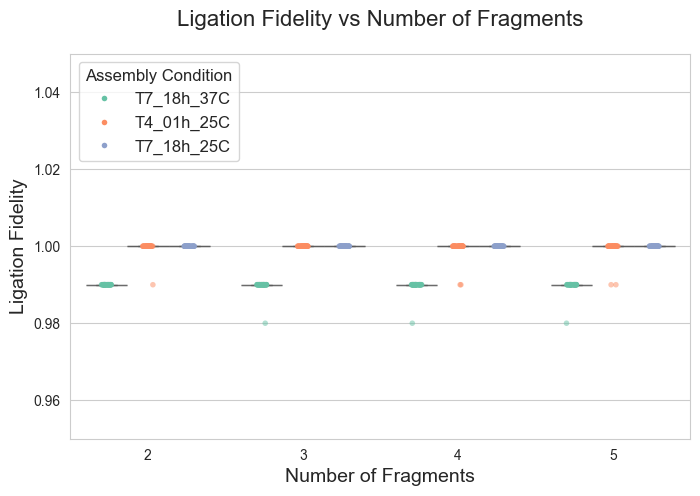

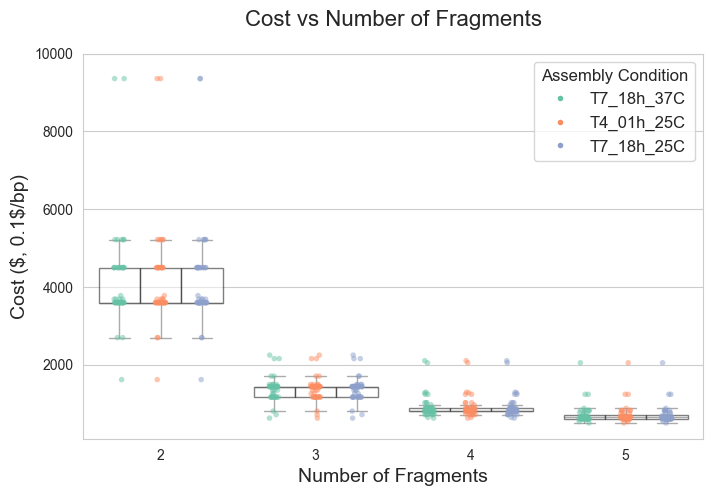

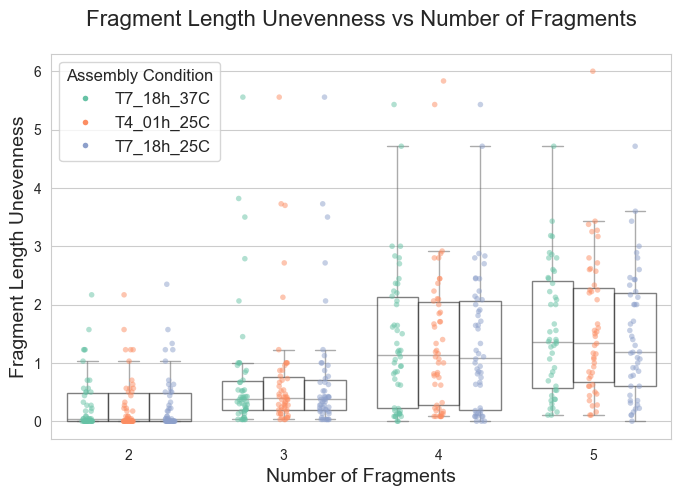

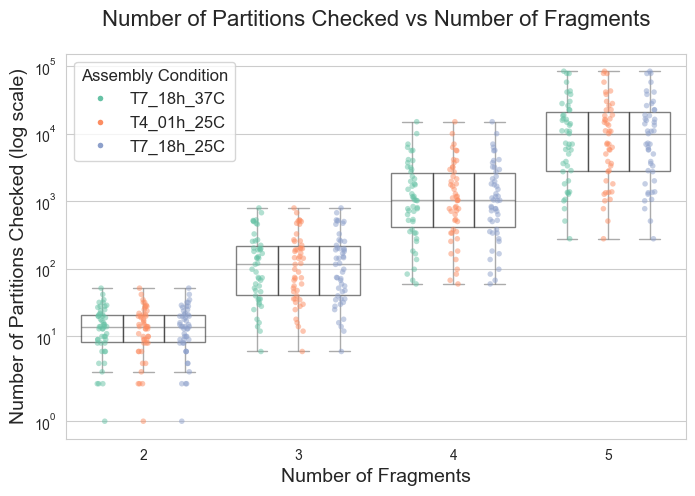

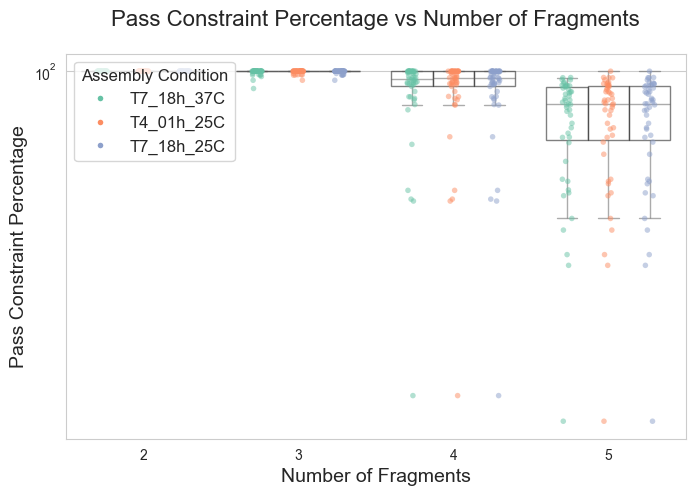

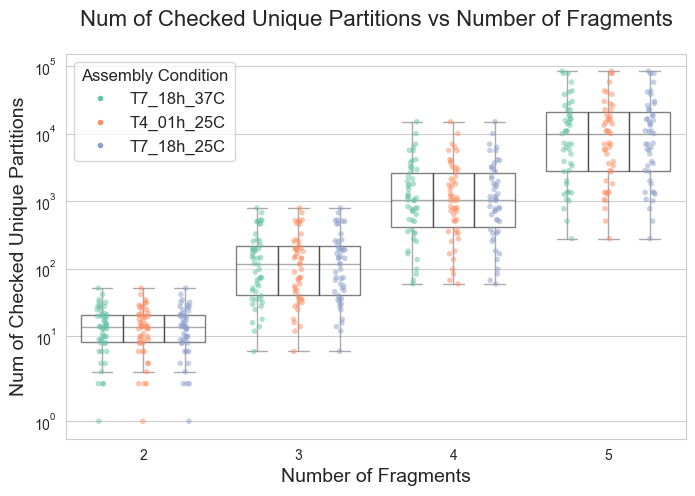

In [39]:
"""Plotting - Jitter + Box Plots"""

input_logy_spec = {
    "elapsed_time":True,
    "ligation_fidelity":False,
    "cost":False,
    "fragment_length_unevenness":False,
    "number_of_partitions_checked":True,
    "pass_constraint_percentage":True,
    "num_of_checked_unique_partitions":True,
    # "elapsed_time_normalized_to_exhaustive":True
}
conds = ["T7_18h_37C",
         "T4_01h_25C",
         "T7_18h_25C"]

my_palette = sns.color_palette("Set2", n_colors=len(conds))

# for x_axis in ['number_of_fragments','seq_length']:
for x_axis in ['number_of_fragments']:

    for y_axis, logy in input_logy_spec.items():
        df = pd.DataFrame(res_data)
        df['assembly_condition'] = pd.Categorical(df['assembly_condition'], conds)
        df = df.sort_values('assembly_condition')
        plt = jitter_box_plot(x_axis, y_axis, df, my_palette, logy=logy)
        plt.show()
